In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [9]:
PATH = 'data'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [10]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 498 files belonging to 2 classes.
Using 399 files for training.


In [11]:
class_names = train_dataset.class_names

In [12]:
class_names

['hot_dog', 'not_hot_dog']

In [13]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 498 files belonging to 2 classes.
Using 99 files for validation.


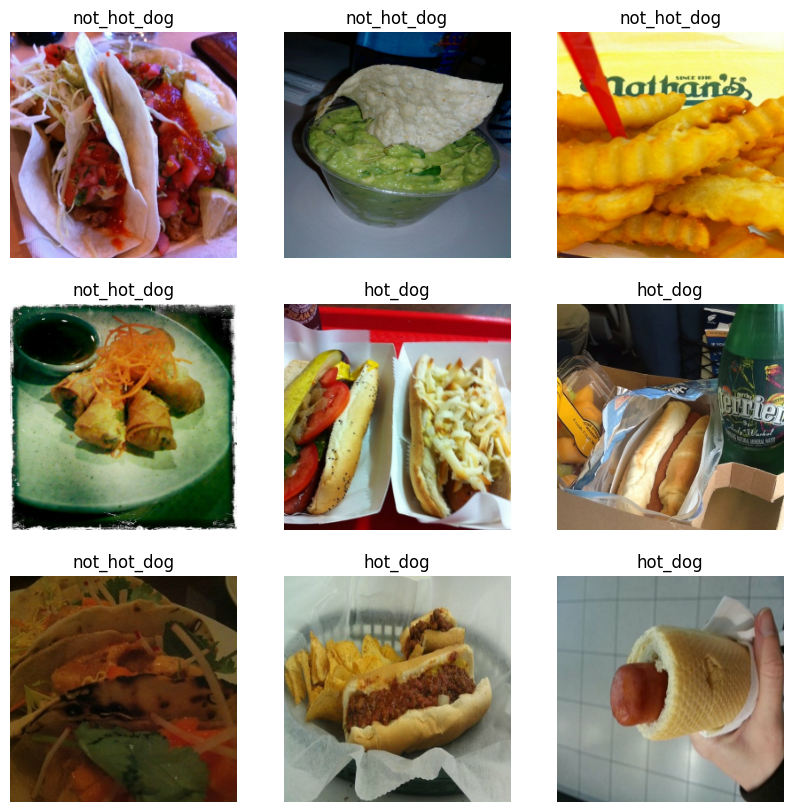

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 500 files belonging to 2 classes.


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

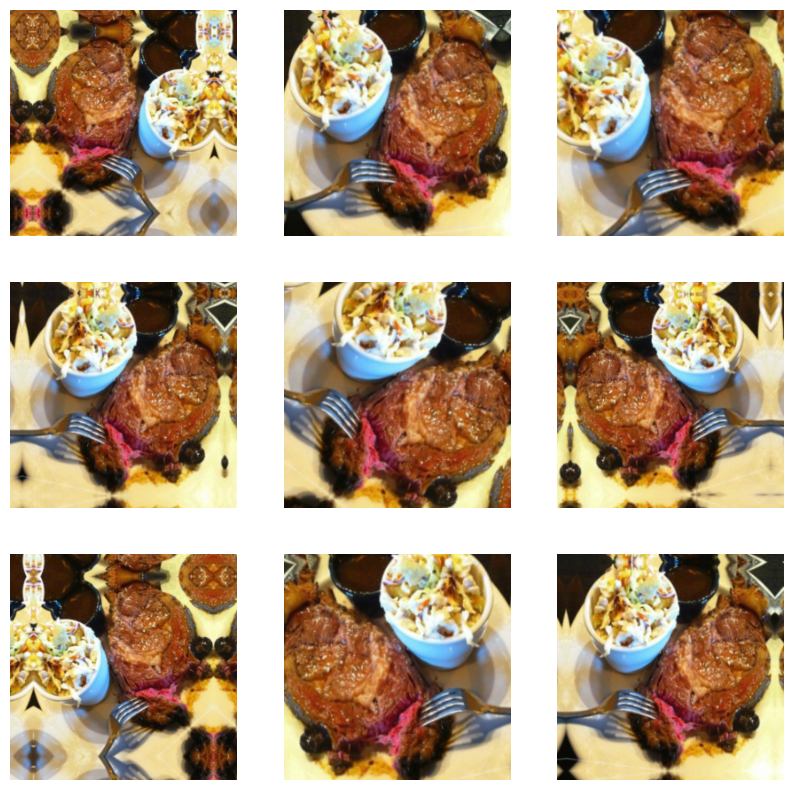

In [19]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [20]:
rescale = preprocessing.Rescaling(1./255)

In [21]:
base_model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

219055592/219055592 [==============================] - 18s 0us/step


In [22]:
base_model_inception_resnet_v2.trainable = False

In [217]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model_inception_resnet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_resnet_v2 = tf.keras.Model(inputs, outputs, name='inception_resnet_v2')

In [218]:
model_inception_resnet_v2.summary()

Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                               

In [219]:
model_inception_resnet_v2.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

In [220]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [221]:
history_inception_resnet_v2 = model_inception_resnet_v2.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])


Epoch 1/10
13/13 [==============================] - 19s 1s/step - loss: 1.0769 - accuracy: 0.7018 - val_loss: 0.3141 - val_accuracy: 0.8485
Epoch 2/10
13/13 [==============================] - 17s 1s/step - loss: 0.4366 - accuracy: 0.8371 - val_loss: 0.2515 - val_accuracy: 0.8889
Epoch 3/10
13/13 [==============================] - 16s 1s/step - loss: 0.2446 - accuracy: 0.8972 - val_loss: 0.2344 - val_accuracy: 0.8990
Epoch 4/10
13/13 [==============================] - 16s 1s/step - loss: 0.2075 - accuracy: 0.9148 - val_loss: 0.3046 - val_accuracy: 0.8788
Epoch 5/10
13/13 [==============================] - 16s 1s/step - loss: 0.1978 - accuracy: 0.9048 - val_loss: 0.2032 - val_accuracy: 0.9091
Epoch 6/10
13/13 [==============================] - 16s 1s/step - loss: 0.1721 - accuracy: 0.9248 - val_loss: 0.2085 - val_accuracy: 0.9192
Epoch 7/10
13/13 [==============================] - 16s 1s/step - loss: 0.1811 - accuracy: 0.9323 - val_loss: 0.2282 - val_accuracy: 0.9091


In [222]:
model_inception_resnet_v2.save('model_inception_resnet_v2.h5')

In [223]:
model_inception_resnet_v2.evaluate(test_dataset)

16/16 [==============================] - 15s 953ms/step - loss: 0.1689 - accuracy: 0.9240


[0.16892889142036438, 0.9240000247955322]

In [224]:
from tensorflow.keras.models import load_model

In [225]:
model = load_model('model_inception_resnet_v2.h5')

In [226]:
model.summary()

Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                               

In [274]:
hotdog_image_path = '/Users/chrisantenesse/hotdogproject/data/test/hot_dog'
not_hotdog_image_path = '/Users/chrisantenesse/hotdogproject/data/test/not_hot_dog'

In [275]:
from keras.preprocessing import image

In [338]:
def load_image(image_path):
    img_width, img_height = 256, 256
    img = image.load_img(image_path, target_size = (img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)

    return img

In [339]:
import os
image_list = []
def get_file_list(directory):    
    for file in os.listdir(directory):
        filename = os.fsdecode(file) 
        image_list.append(os.path.join(directory, filename))

    return image_list

In [340]:
for i in get_file_list(hotdog_image_path):
    img = load_image(i)
    prediction = model.predict(img).flatten()
    prediction = tf.nn.sigmoid(prediction)
    prediction = tf.where(prediction <= 0.5, 0, 1)
    if (prediction.numpy()[0]) == 0:
        print("hot dog")
    else:
        print("not hot dog")
    

1/1 [==============================] - 0s 95ms/step
hot dog
1/1 [==============================] - 0s 91ms/step
hot dog
1/1 [==============================] - 0s 91ms/step
hot dog
1/1 [==============================] - 0s 92ms/step
hot dog
1/1 [==============================] - 0s 91ms/step
hot dog
1/1 [==============================] - 0s 91ms/step
hot dog
1/1 [==============================] - 0s 93ms/step
hot dog
1/1 [==============================] - 0s 95ms/step
hot dog
1/1 [==============================] - 0s 96ms/step
hot dog
1/1 [==============================] - 0s 92ms/step
hot dog
1/1 [==============================] - 0s 101ms/step
hot dog
1/1 [==============================] - 0s 100ms/step
hot dog
1/1 [==============================] - 0s 94ms/step
hot dog
1/1 [==============================] - 0s 96ms/step
hot dog
1/1 [==============================] - 0s 95ms/step
hot dog
1/1 [==============================] - 0s 96ms/step
hot dog
1/1 [==============================] -